<a href="https://colab.research.google.com/github/gmvarshini/Sentiment-Analysis-on-Tweets/blob/main/Sentiment_Analysis_on_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4D1873 ;font-family:arial;color:#FFFFFF;font-size:170%;text-align:center;border-radius:55px 1px;">IMPORT NECESSARY LIBRARIES</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import ensemble
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from textblob import Word
nltk.download('wordnet')

from termcolor import colored
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(print_changed_only = False)

print(colored("\nLIBRARIES WERE SUCCESFULLY IMPORTED...", color = "green", attrs = ["dark", "bold"]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...



LIBRARIES WERE SUCCESFULLY IMPORTED...


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4D1873 ;font-family:arial;color:#FFFFFF;font-size:170%;text-align:center;border-radius:55px 1px;">LOAD DATASETS</p>

In [2]:
train_set = pd.read_csv("/content/train.csv",
                   encoding = "utf-8",
                   engine = "python",
                   header = 0)

test_set = pd.read_csv("/content/test.csv",
                   encoding = "utf-8",
                   engine = "python",
                   header = 0)

print(colored("\nDATASETS WERE SUCCESFULLY LOADED...", color = "green", attrs = ["dark", "bold"]))


DATASETS WERE SUCCESFULLY LOADED...


### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;">The first five rows of train set</span>

In [3]:
train_set.head(n = 5).style.background_gradient(cmap = "summer")

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;">The first five rows of test set</span>

In [4]:
test_set.head(n = 5).style.background_gradient(cmap = "summer")

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦
1,31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why
2,31965,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!
3,31966,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #favorite"
4,31967,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦"


### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;">Shapes of the train and test sets</span>

In [5]:
print("Train set shape: {} and test set shape: {}".format(train_set.shape, test_set.shape))

Train set shape: (31962, 3) and test set shape: (17197, 2)


### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;">Get general information about train set</span>

In [6]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;">Check whether there are duplicated values</span>

In [7]:
print("Totally there are {} duplicated values in train_set".format(train_set.duplicated().sum()))

Totally there are 0 duplicated values in train_set


### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;">Get the number of classes of the "label" variable of train set</span>

In [8]:
train_set.groupby("label").count().style.background_gradient(cmap = "summer")

,id,tweet
label,,
0,29720,29720
1,2242,2242


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4D1873 ;font-family:arial;color:#FFFFFF;font-size:170%;text-align:center;border-radius:55px 1px;">CLEAN AND PROCESS DATASET</p>

### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;">Convert uppercase letters to lowercase letters in "tweet" columns</span>

In [9]:
train_set["tweet"] = train_set["tweet"].apply(lambda x: " ".join(x.lower() for x in x.split()))
test_set["tweet"] = test_set["tweet"].apply(lambda x: " ".join(x.lower() for x in x.split()))

print(colored("\nCONVERTED SUCCESFULLY...", color = "green", attrs = ["dark", "bold"]))


CONVERTED SUCCESFULLY...


### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;">Delete punctuation marks from "tweet" columns</span>

In [10]:
train_set["tweet"] = train_set["tweet"].str.replace('[^\w\s]','')
test_set["tweet"] = test_set["tweet"].str.replace('[^\w\s]','')

print(colored("\nDELETED SUCCESFULLY...", color = "green", attrs = ["dark", "bold"]))


DELETED SUCCESFULLY...


### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;">Delete numbers from "tweet" columns</span>

In [11]:
train_set['tweet'] = train_set['tweet'].str.replace('\d','')
test_set['tweet'] = test_set['tweet'].str.replace('\d','')

print(colored("\n NUMBERS DELETED SUCCESFULLY...", color = "green", attrs = ["dark", "bold"]))


 NUMBERS DELETED SUCCESFULLY...


### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;">Delete stopwords from "tweet" columns</span>

In [12]:
sw = stopwords.words("english")
train_set['tweet'] = train_set['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
test_set['tweet'] = test_set['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

print(colored("\nSTOPWORDS DELETED SUCCESFULLY...", color = "green", attrs = ["dark", "bold"]))


STOPWORDS DELETED SUCCESFULLY...


### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;">Lemmatization. That is, we get the roots of the words in the "tweet" columns</span>

In [13]:
train_set['tweet'] = train_set['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
test_set['tweet'] = test_set['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 

print(colored("\nDONE SUCCESFULLY...", color = "green", attrs = ["dark", "bold"]))


DONE SUCCESFULLY...


### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;">Drop "id" column from datasets</span>

In [14]:
train_set = train_set.drop("id", axis = 1)
test_set = test_set.drop("id", axis = 1)

print(colored("\n'ID' COLUMNS DROPPED SUCCESFULLY...", color = "green", attrs = ["dark", "bold"]))


'ID' COLUMNS DROPPED SUCCESFULLY...


### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;">Look at the latest condition of train set
</span>

In [15]:
train_set.head(n = 10)

,label,tweet
0,0,user father dysfunctional selfish drag kid dys...
1,0,user user thanks lyft credit cant use cause do...
2,0,bihday majesty
3,0,model love u take u time urð ðððð ððð
4,0,factsguide society motivation
5,0,huge fan fare big talking leave chaos pay disp...
6,0,user camping tomorrow user user user user user...
7,0,next school year year examsð cant think ð scho...
8,0,love land allin cavs champion cleveland clevel...
9,0,user user welcome im gr


### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;">Look at the latest condition of test set</span>

In [16]:
test_set.head(n = 10)

,tweet
0,studiolife aislife requires passion dedication...
1,user white supremacist want everyone see new â...
2,safe way heal acne altwaystoheal healthy healing
3,hp cursed child book reservation already yes ð...
4,rd bihday amazing hilarious nephew eli ahmir u...
5,choose momtips
6,something inside dy ððâ eye ness smokeyeyes ti...
7,finishedtattooinkedinkloveitâï âïâïâïâï thanks...
8,user user user never understand dad left young...
9,delicious food lovelife capetown mannaepicure ...


### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;">Divide datasets</span>

In [17]:
x = train_set["tweet"]
y = train_set["label"]

train_x, test_x, train_y, test_y = model_selection.train_test_split(x, y, test_size = 0.20, shuffle = True, random_state = 11)

print(colored("\nDIVIDED SUCCESFULLY...", color = "green", attrs = ["dark", "bold"]))


DIVIDED SUCCESFULLY...


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4D1873 ;font-family:arial;color:#FFFFFF;font-size:170%;text-align:center;border-radius:55px 1px;">VECTORIZE DATA</p>

### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;">"Count Vectors" method</span>

In [18]:
vectorizer = CountVectorizer()
vectorizer.fit(train_x)

x_train_count = vectorizer.transform(train_x)
x_test_count = vectorizer.transform(test_x)

x_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;">"TF-IDF" method</span>

In [19]:
tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit(train_x)

x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

x_train_tf_idf_word.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4D1873 ;font-family:arial;color:#FFFFFF;font-size:170%;text-align:center;border-radius:55px 1px;">BUILD MACHINE LEARNING MODELS</p>

### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;">Logistic regression model with "count-vectors" method</span>

In [20]:
log = linear_model.LogisticRegression()
log_model = log.fit(x_train_count, train_y)
accuracy = model_selection.cross_val_score(log_model,
                                           x_test_count,
                                           test_y,
                                           cv = 20).mean()

print(colored("\nLogistic regression model with 'count-vectors' method", color = "red", attrs = ["dark", "bold"]))
print(colored("Accuracy ratio: ", color = "red", attrs = ["dark", "bold"]), accuracy)


Logistic regression model with 'count-vectors' method
Accuracy ratio:  0.9480686716300942


### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;">Logistic regression model with "tf-idf" method</span>

In [21]:
log = linear_model.LogisticRegression()
log_model = log.fit(x_train_tf_idf_word, train_y)
accuracy = model_selection.cross_val_score(log_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()

print(colored("\nLogistic regression model with 'tf-idf' method", color = "red", attrs = ["dark", "bold"]))
print(colored("Accuracy ratio: ", color = "red", attrs = ["dark", "bold"]), accuracy)


Logistic regression model with 'tf-idf' method
Accuracy ratio:  0.9307072884012537


### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;">XGBoost model with "count-vectors" method</span>

In [22]:
xgb = XGBClassifier()
xgb_model = xgb.fit(x_train_count,train_y)
accuracy = model_selection.cross_val_score(xgb_model,
                                           x_test_count,
                                           test_y,
                                           cv = 20).mean()

print(colored("\nXGBoost model with 'count-vectors' method", color = "red", attrs = ["dark", "bold"]))
print(colored("Accuracy ratio: ", color = "red", attrs = ["dark", "bold"]), accuracy)


XGBoost model with 'count-vectors' method
Accuracy ratio:  0.9427547021943574


### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;">XGBoost model with "tf-idf" method</span>

In [23]:
xgb = XGBClassifier()
xgb_model = xgb.fit(x_train_tf_idf_word,train_y)
accuracy = model_selection.cross_val_score(xgb_model, 
                                           x_test_tf_idf_word, 
                                           test_y, 
                                           cv = 20).mean()

print(colored("\nXGBoost model with 'tf-idf' method", color = "red", attrs = ["dark", "bold"]))
print(colored("Accuracy ratio: ", color = "red", attrs = ["dark", "bold"]), accuracy)


XGBoost model with 'tf-idf' method
Accuracy ratio:  0.9397820336990594


### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;">Light GBM model with "count-vectors" method</span>

In [24]:
lgbm = LGBMClassifier()
lgbm_model = lgbm.fit(x_train_count.astype("float64"), train_y)
accuracy = model_selection.cross_val_score(lgbm_model,
                                           x_test_count.astype("float64"),
                                           test_y,
                                           cv = 20).mean()

print(colored("\nLight GBM model with 'count-vectors' method", color = "red", attrs = ["dark", "bold"]))
print(colored("Accuracy ratio: ", color = "red", attrs = ["dark", "bold"]), accuracy)


Light GBM model with 'count-vectors' method
Accuracy ratio:  0.9368064263322884


### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;"> Light GBM model with "tf-idf" method</span>

In [25]:
lgbm = LGBMClassifier()
lgbm_model = lgbm.fit(x_train_tf_idf_word,train_y)
accuracy = model_selection.cross_val_score(lgbm_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()

print(colored("\nLight GBM model with 'tf-idf' method", color = "red", attrs = ["dark", "bold"]))
print(colored("Accuracy ratio: ", color = "red", attrs = ["dark", "bold"]), accuracy)


Light GBM model with 'tf-idf' method
Accuracy ratio:  0.9372771355799374


### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;"> ROC AUC (curvature)</span>

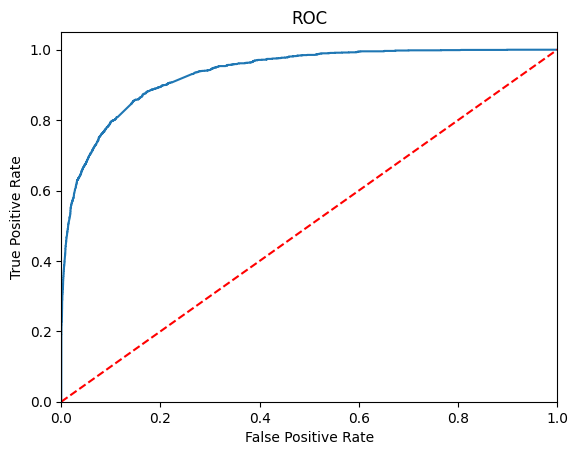

In [26]:
y = train_y
X = x_train_count.astype("float64")

logit_roc_auc = roc_auc_score(y, lgbm_model.predict(X))

fpr, tpr, thresholds = roc_curve(y, lgbm_model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4D1873 ;font-family:arial;color:#FFFFFF;font-size:170%;text-align:center;border-radius:55px 1px;">ESTIMATION OVER TEST SET</p>

### <span style = "background:#4D1873; font-size:100%; color:#fff; border-radius:0px;"> Look at the first 5 rows of the test set</span>

In [27]:
test_set.head()

,tweet
0,studiolife aislife requires passion dedication...
1,user white supremacist want everyone see new â...
2,safe way heal acne altwaystoheal healthy healing
3,hp cursed child book reservation already yes ð...
4,rd bihday amazing hilarious nephew eli ahmir u...


## <mark>Here we encode values of "tweet" column of test set with "count-vectors" method.</mark>

In [28]:
vectorizer = CountVectorizer()
vectorizer.fit(train_x)
test_set = vectorizer.transform(test_set["tweet"])
test_set.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [29]:
lgbm_model.predict(test_set.astype("float"))[0:5]

array([0, 1, 0, 0, 0])

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4D1873 ;font-family:arial;color:#FFFFFF;font-size:170%;text-align:center;border-radius:55px 1px;">VISUALIZATION WITH WORD CLOUD</p>

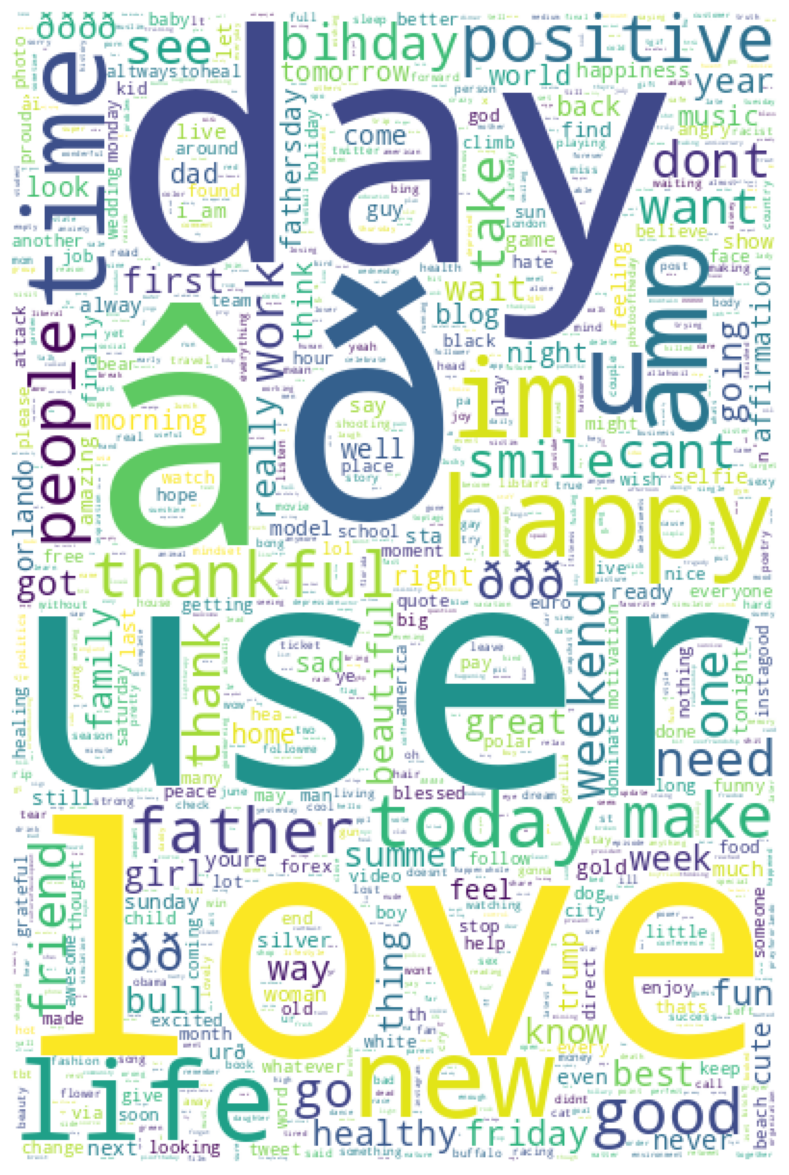

In [32]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image


text = " ".join(i for i in train_set.tweet)

wc = WordCloud(background_color = "white",
               height = 600,
               contour_width = 0,
               contour_color = "red",
               max_words = 1000,
               scale = 1,
               collocations = False,
               repeat = True,
               min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 15])
plt.imshow(wc)
plt.axis("off")
plt.show;